In [158]:
import numpy as np
from scipy.spatial import distance
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.metrics import normalized_mutual_info_score


np.seterr(divide='ignore', invalid='ignore')

NOISE = 0

In [159]:
def point_in_hull(point, hull):
    '''
    Check if a point is inside the convex hull.
    '''
    return all((np.dot(eq[:-1], point) + eq[-1] <= 0) for eq in hull.equations)

def degree_of_convexity_cluster(cluster_points):
    '''
    Build the convex hull around cluster. 
    Find the number of points in the hull. 
    Divide the number of points in the class 
    by the number of points inside the hull
    '''
    if len(cluster_points) < 4:
        return 1
    else:
        try:
            hull = ConvexHull(cluster_points)
            in_hull = [p for p in cluster_points if point_in_hull(p, hull)]
            return len(in_hull) / (len(cluster_points) + 1)
        except:
            return 0 

def degree_of_convexity(arrays):
    '''Compute the degree of convexity for the given array or arrays'''
    convexity_list = []
    for arr in arrays:
        labels = np.unique(arr)  # Get unique labels
        convexities = [degree_of_convexity_cluster(np.argwhere(arr == label)) for label in labels]
        weights = [np.sum(arr == label) for label in labels]
        convexity = np.average(convexities, weights=weights)
        convexity_list.append(convexity)
    return np.array(convexity_list)

# Given arrays
arrays = np.array([[[2, 2, 2, 0],
                    [1, 0, 0, 2],
                    [0, 2, 2, 1],
                    [0, 1, 1, 2]],

                   [[1, 2, 1, 0],
                    [2, 0, 2, 2],
                    [2, 0, 1, 0],
                    [2, 1, 1, 2]],

                   [[1, 2, 2, 2],
                    [1, 2, 1, 1],
                    [1, 2, 0, 0],
                    [2, 2, 0, 1]],

                   [[0, 1, 2, 0],
                    [1, 2, 1, 1],
                    [0, 2, 2, 1],
                    [0, 1, 2, 1]],

                   [[2, 1, 2, 2],
                    [0, 2, 2, 1],
                    [0, 2, 0, 0],
                    [0, 2, 1, 2]]])

convexities = degree_of_convexity(arrays)
print("Degrees of Convexity:", convexities)

Degrees of Convexity: [0.84322917 0.84322917 0.83816964 0.78854167 0.84027778]


In [160]:
arrays.shape

(5, 4, 4)

In [161]:
def calculate_upper_bound(N, shape):
    total_elements = np.prod(shape)
    return min(N**total_elements, N ** max(0, total_elements - N + 1))


In [162]:
def generate_lexicons(N, shape, n):
    total_elements = np.prod(shape)
    upper_bound = min(N**total_elements, N ** max(0, total_elements - N + 1))
    lexicons = set()

    while len(lexicons) < min(n, upper_bound):
        lexicon = tuple(map(tuple, np.random.randint(0, N, shape)))
        lexicons.add(lexicon)

    return np.array([list(lexicon) for lexicon in lexicons])

In [163]:
degree_of_convexity(generate_lexicons(3, (4, 4), 10)).max()

0.9423076923076923

In [164]:
class BaseRSA:
    def __init__(self, alpha, prior):
        self.alpha = alpha
        self.prior = prior

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)
        
    @staticmethod
    def binary_language(L):
        max_labels = np.max([np.max(subarray) for subarray in L]) + 1
        binary_arrays = []
        for subarray in L:
            x = max_labels
            y = np.prod(subarray.shape)
            binary_array = np.zeros((x, y), dtype=np.uint8)
            for i, row in enumerate(subarray):
                for j, val in enumerate(row):
                    binary_array[val, i * subarray.shape[1] + j] = 1
            binary_arrays.append(binary_array)
        return np.array(binary_arrays)
    
    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
    
    @staticmethod
    def cost(L):
        # for each unique label, compute pairwise distance between all points
        # and sum them up
        cost_arrays = []
        unique_labels = np.unique(L)
        for subarray in L:
            cost_p = np.zeros(max(unique_labels) + 1)
            for c in unique_labels:
                coords = np.argwhere(subarray == c)
                for m in coords:
                    for n in coords:
                        cost_p[c] += distance.euclidean(m, n)
                cost_p[c] = cost_p[c] / (len(coords) * (len(coords)))
            cost_arrays.append(cost_p)
        return np.nan_to_num(np.expand_dims(np.array(cost_arrays), axis=1))

    def L_0(self, L):
        '''Literal listener'''
        return self.normalize(self.binary_language(L) * self.prior )  
        # *  self.informativeness(L)
    
    def S_p(self, L):
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)))))
        # return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)) - self.cost(L))))
    
    def L_p(self, L):
        return self.normalize(self.S_p(L).transpose(0, 2, 1) * self.prior)
        # * self.informativeness(L)


In [166]:
L = generate_lexicons(4, (2, 2), 5)

In [167]:
L

array([[[1, 0],
        [0, 2]],

       [[1, 2],
        [2, 2]],

       [[2, 3],
        [3, 0]],

       [[2, 2],
        [0, 2]]])

In [168]:
rsa = BaseRSA(10, np.ones(4) / 4)

In [169]:
rsa.L_0(L)

array([[[0.        , 0.5       , 0.5       , 0.        ],
        [1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.33333333, 0.33333333, 0.33333333],
        [0.        , 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 1.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [1.        , 0.        , 0.        , 0.        ],
        [0.        , 0.5       , 0.5       , 0.        ]],

       [[0.        , 0.        , 1.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.33333333, 0.33333333, 0.        , 0.33333333],
        [0.        , 0.        , 0.        , 0.        ]]])

In [170]:
rsa.cost(L)

array([[[0.70710678, 0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.75871412, 0.        ]],

       [[0.        , 0.        , 0.        , 0.70710678]],

       [[0.        , 0.        , 0.75871412, 0.        ]]])

In [171]:
rsa.S_p(L)

array([[[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]],

       [[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]]])

In [172]:
def find_rectangular_zones(matrix):
    visited = np.zeros_like(matrix, dtype=bool)
    zones = []

    def dfs(r, c, value, zone):
        if r < 0 or r >= rows or c < 0 or c >= cols or visited[r][c] or matrix[r][c] != value:
            return
        zone.append((r, c))
        visited[r][c] = True
        for dr, dc in ((1, 0), (-1, 0), (0, 1), (0, -1)):
            dfs(r + dr, c + dc, value, zone)

    rows, cols = matrix.shape
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j]:
                zone = []
                dfs(i, j, matrix[i][j], zone)
                if len(zone) > 1:
                    zones.append(zone)

    return zones

def create_candidate(grid):
    zone = find_rectangular_zones(grid)
    if len(zone) == 0:
        return grid
    zone = zone[np.random.randint(0, len(zone))]
    value = np.random.randint(1, max(grid.flatten()) + 1)
    candidate = np.copy(grid)
    for r, c in zone:
        candidate[r, c] = value
    return candidate

def create_candidates(arr):
    candidates = []
    for matrix in arr:
        candidates.append(create_candidate(matrix))
    return np.array(candidates)

In [194]:
class Agent(BaseRSA):
    def __init__(self, alpha, prior, N, shape, convex, Lexicons, convexities, treshold, beta):
        super().__init__(alpha, prior)
        self.n_words = N
        self.n_meanings = shape[0] * shape[1]

        self.Lexicons = Lexicons
        self.convexities = convexities

        self.convex = convex
        self.beta = beta
        
        self.Lexicons = self.Lexicons[self.convexities > treshold]
        self.convexities = self.convexities[self.convexities > treshold]
        
        self.prob_lexicon = np.ones(len(self.Lexicons)) / len(self.Lexicons)

        self.precompute_S_p()
        self.precompute_L_p()
    
    def precompute_S_p(self):
        self.S_p_values = self.S_p(self.Lexicons)
    
    def precompute_L_p(self):
        self.L_p_values = self.L_p(self.Lexicons)
    
    def speaker(self, m):
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        if np.sum(self.S_p_values[lexicon_idx][m]) == 0:
            return np.random.choice(np.arange(self.n_words), p=[1 / self.n_words] * self.n_words)
        else:
            return np.random.choice(np.arange(self.n_words), p=self.S_p_values[lexicon_idx][m])
    
    def listener(self, w):
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        if np.sum(self.L_p_values[lexicon_idx][w]) == 0:
            return np.random.choice(np.arange(self.n_meanings), p=[1 / self.n_meanings] * self.n_meanings)
        else:
            return np.random.choice(np.arange(self.n_meanings), p=self.L_p_values[lexicon_idx][w])

    def update(self, w, m, correct, role):
        if self.convex:
            self.prob_lexicon = self.normalize(self.convexities**(1/self.beta) * self.prob_lexicon)
        if role == "speaker":
            if correct:
                self.prob_lexicon = self.normalize(self.S_p_values[:, m, w] \
                                                    * self.prob_lexicon + NOISE)
        elif role == "listener":
            if correct:
                self.prob_lexicon = self.normalize(self.L_p_values[:, w, m] \
                                                        * self.prob_lexicon  + NOISE)


class Experiment:
    def __init__(self, alpha, prior, shape, n, n_iter, n_rounds, N, convex, treshold, beta):
        self.n_iter = n_iter
        self.n_rounds = n_rounds

        self.logs = defaultdict(lambda: defaultdict(dict))
        
        self.lexicons = {}

        self.alpha = alpha
        self.prior = prior
        self.convex = convex

        self.treshold = treshold
        self.beta = beta

        self.shape = shape
        if n > 300000:
            self.n = 300000
        else:
            self.n = n 
            self.treshold = 0
        self.N = N


    def sample_meaning(self):
        return np.random.choice([i for i in range(self.shape[0] * self.shape[1])])

    def one_round(self, a, b, m, i, r):
        w = a.speaker(m)
        g = b.listener(w)

        a.update(w, m, m == g, "speaker")
        b.update(w, m, m == g, "listener")

        self.logs[i][r]['word'] = w
        self.logs[i][r]['guess'] = g
        self.logs[i][r]['correct'] = 1 if (m == g) else 0
    
    def run(self):
        
        Lexicons = generate_lexicons(N=self.N, shape=self.shape, n=self.n)
        convexities = degree_of_convexity(Lexicons)
        
        for i in range(self.n_iter):
            p1 = np.random.permutation(len(Lexicons))
            p2 = np.random.permutation(len(Lexicons))
            agents = [Agent(alpha=self.alpha, prior=self.prior, N=self.N, 
                            shape=self.shape, convex=self.convex, 
                            Lexicons= Lexicons[p1], convexities=convexities[p1], 
                            treshold=self.treshold, beta=self.beta),
                      Agent(alpha=self.alpha, prior=self.prior, N=self.N, 
                            shape=self.shape, convex=self.convex, 
                            Lexicons=Lexicons[p2], convexities=convexities[p2], 
                            treshold=self.treshold, beta=self.beta)]

            lexicons_ = {'a1': [], 'a2': []}
            for r in range(self.n_rounds):

                lexicons_['a1'].append(agents[0].Lexicons[np.argmax(agents[0].prob_lexicon)])
                lexicons_['a2'].append(agents[1].Lexicons[np.argmax(agents[1].prob_lexicon)])
                
                m = self.sample_meaning()
                self.logs[i][r]['meaning'] = m
                if r % 2 == 0:
                    self.one_round(agents[0], 
                                   agents[1], 
                                   m, i, r)
                else:
                    self.one_round(agents[1], 
                                   agents[0], 
                                    m, i, r)
                

            self.lexicons[i] = lexicons_
    
                        
    def save(self, rd=False):
        df = pd.DataFrame.from_dict({(i, r): self.logs[i][r]
                                        for i in self.logs.keys()
                                        for r in self.logs[i].keys()},
                                        orient='index').reset_index()
        df.columns = ['trial', 'round', 'meaning', 'word',
                      'guess', 'correct']
        if not rd:
            df.to_csv(f'src/data/logs/logs-{self.n_iter}-{self.model}-{self.n_rounds}.csv', index=False)
        else:
            return df

In [267]:
def plot_last_lexicons(model, n_iter, pos=-1):
    fig, ax = plt.subplots(2, 10)

    for i, l in enumerate(np.random.choice(range(n_iter), 10, replace=False)):
        ax[0, i].imshow(model.lexicons[l]['a1'][pos], cmap='tab20', interpolation='none')
        ax[1, i].imshow(model.lexicons[l]['a2'][pos], cmap='tab20', interpolation='none')  
        # remove axes 
        ax[0, i].axis('off')
        ax[1, i].axis('off') 

        # add iteration number on top
        ax[0, i].set_title(f"{i}") 

    # add labels on the left saying A1 A2
    ax[0, 0].set_ylabel('A1')
    ax[1, 0].set_ylabel('A2')
    plt.tight_layout()
    # remove gaps between subplots    plt.show()

In [268]:
def calculate_normalized_mutual_info(data, n_iter, n_rounds):
    mis = []

    for k in range(n_iter):
        mi = []
        for i in range(n_rounds):
            mi.append(normalized_mutual_info_score(data.lexicons[k]['a1'][i].ravel(), 
                                                  data.lexicons[k]['a2'][i].ravel()))

        mis.append(mi)

    df = pd.DataFrame(mis).melt()
    return df

In [390]:
n_iter = 100
n_rounds = 200
N = 3
shape = (3, 3)

In [391]:
# L = generate_lexicons(N, shape, calculate_upper_bound(N, shape))

# degree_of_convexity(L)

In [392]:
calculate_upper_bound(N, shape)

2187

In [393]:
a = Experiment(alpha=5, 
               shape=shape, 
               n=calculate_upper_bound(N, shape), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0], 
               N=N,
               convex=True,
               treshold=0.9,
               beta=0.01)
a.run()
mi_convex = calculate_normalized_mutual_info(a, n_iter, n_rounds)

In [394]:
b = Experiment(alpha=5, 
               shape=shape, 
               n=calculate_upper_bound(N, shape), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0], 
               N=N,
               convex=False, 
               treshold=0.9,
               beta=1)
b.run()
mi_nconvex = calculate_normalized_mutual_info(b, n_iter, n_rounds)

In [395]:
a.lexicons[0]['a2'][0]

array([[0, 1, 2],
       [0, 1, 1],
       [1, 1, 1]])

In [396]:
a.lexicons[0]['a2'][-1]

array([[0, 1, 1],
       [2, 0, 2],
       [0, 2, 1]])

In [397]:
# generate 1000 random matrices and compute the baseline
baseline = []

for i in range(1000):
    baseline.append(normalized_mutual_info_score(np.random.randint(0, N, shape).ravel(),   
                                                 np.random.randint(0, N, shape).ravel()))

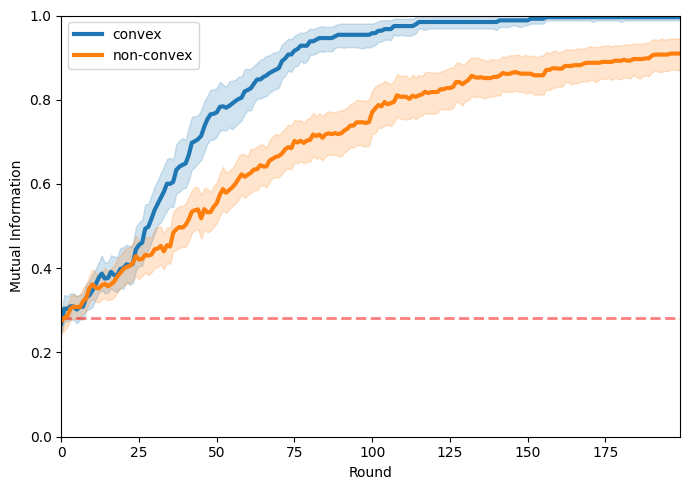

In [398]:
fig, ax = plt.subplots(figsize=(7, 5))
# for mi in mis:
#     plt.plot(mi, color = 'blue', alpha=0.05, linewidth=3)
# plot mean mutual information
# plot the baseline
plt.axhline(y=np.mean(baseline), 
            color='r', 
            linestyle='--', 
            linewidth=2, 
            alpha=0.5)
sns.lineplot(x="variable", 
             y="value", 
             data=mi_convex,
             linewidth=3,
             label='convex')
sns.lineplot(x="variable", 
             y="value", 
             data=mi_nconvex,
             linewidth=3,
             label='non-convex')
plt.ylim(0, 1)
plt.xlabel('Round')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.legend()
# log space y 
# ax.set_yscale('log')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# ax.minorticks_on()
plt.margins(x=0)
plt.show()

In [399]:
# for every variable in mi_nconvex, add a new column with range(n_iter) and then melt the dataframe
mi_nconvex['group'] = list(range(n_iter)) * n_rounds
mi_convex['group'] = list(range(n_iter)) * n_rounds

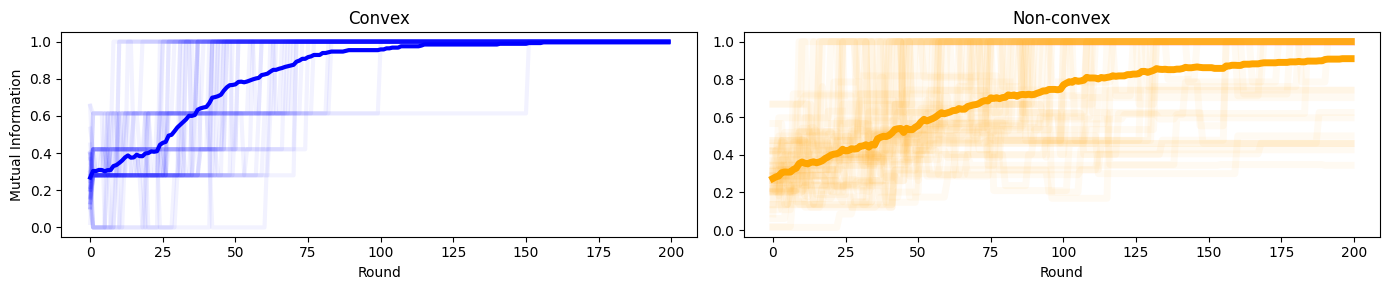

In [400]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

# Convex subplot
ax1.set_title('Convex')
for group in mi_convex.group.unique():
    if group % 2 == 0:
        ax1.plot(range(200), mi_convex[mi_convex.group == group].value, 
                 color='blue', alpha=0.05, linewidth=3)

# plot mean mutual information by grouping by variable
ax1.plot(range(200), mi_convex.groupby('variable').value.mean(), color='blue', linewidth=3)

# Non-convex subplot
ax2.set_title('Non-convex')
for group in mi_nconvex.group.unique():
    if group % 2 == 0:
        ax2.plot(range(200), mi_nconvex[mi_nconvex.group == group].value, 
                 color='orange', alpha=0.05, linewidth=5)

# plot mean mutual information by grouping by variable
ax2.plot(range(200), mi_nconvex.groupby('variable').value.mean(), color='orange', linewidth=5)

ax1.set_xlabel('Round')
ax1.set_ylabel('Mutual Information')
ax2.set_xlabel('Round')

plt.tight_layout()
plt.show()


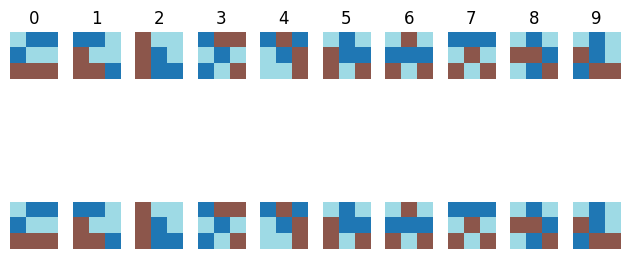

In [401]:
plot_last_lexicons(a, n_iter, pos=-1)

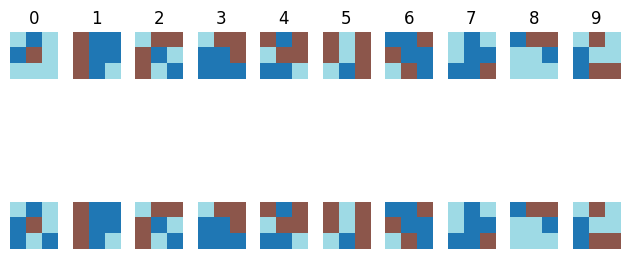

In [402]:
plot_last_lexicons(b, n_iter, pos=-1)